In [1]:
from math import sqrt

import matplotlib.pyplot as plt
import numpy as np
import torch as th

plt.rc('font', family='serif')
plt.rc('text', usetex=True)

In [2]:
def modular_class(x, m):
    return x % m


def squared_modular_class(x, m):
    return (x**2) % m


def get_embeddings(n, d, norm=True):
    emb = th.randn(n, d)
    if norm:
        emb /= emb.norm(dim=1, keepdim=True)
    else:
        emb /= sqrt(d)
    return emb

Scaling with respect to T and d jointly

In [3]:
# number of input tokens
n = 1000
# number of output classes
m = 5
# memory dimension
ds = [10, 20, 50, 100, 200, 1000]
dmax = np.max(ds)

# number of data
ts = [10, 100, 1000, 10000]
tmax = np.max(ts)

# Zipf parameter
alpha = 2

In [4]:
# Population data
all_x = th.arange(n)
proba = (all_x + 1.) ** (-alpha)
proba /= proba.sum()
all_y = modular_class(all_x, m)

In [5]:
P = None
rho = 0

nb_trials = 100

errors = th.zeros(nb_trials, len(ts), len(ds))
errors[:] = -1

for i_n in range(nb_trials):
    # Embeddings
    E = get_embeddings(n, dmax, norm=False)
    U = get_embeddings(m, dmax, norm=True)
    x = th.multinomial(proba, tmax, replacement=True)
    y = all_y[x]

    for i_t, t in enumerate(ts):

        counts = th.bincount(x[:t])
        _, order = th.sort(counts, descending=True)
        P = th.sum(counts!=0).item()
        idx = order[:P]
        q = (counts[idx] / counts[idx].sum())**rho

        for i_d, d in enumerate(ds):
            P = int(d / 12)
            W = (E[idx[:P]].T * q[:P]) @ U[all_y[idx[:P]]]

            scores = E[:, :d] @ W[:d,:d] @ U[:,:d].T
            preds = scores.argmax(dim=1)
            errors[i_n, i_t, i_d] = proba[preds != all_y].sum()

        # print(len(idx), end=',')
    print(i_n, end=',')

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,

In [6]:
errors_mean = errors.mean(dim=0)
errors_std = errors.std(dim=0)

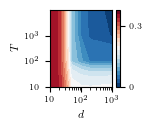

In [7]:
X, Y = np.meshgrid(ds, ts)
fig, ax = plt.subplots(figsize=(1, 1))
c = ax.contourf(X, Y, errors_mean.numpy(), levels=20, cmap='RdBu_r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([10, 100, 1000])
ax.set_xticklabels(["10", "$10^2$", r"$10^3$"], fontsize=6)
ax.set_yticks([10, 100, 1000])
ax.set_yticklabels(["10", r"$10^2$", r"$10^3$"], fontsize=6)
ax.set_xlabel('$d$', fontsize=8)
ax.set_ylabel('$T$', fontsize=8)
bar = fig.colorbar(c, ax=ax, ticks=[0, .3, .6, .9])
bar.set_ticklabels([r"$0$", r"$0.3$", r"$0.6$", r"$0.9$"], fontsize=6)
fig.savefig('thres_storage_error.pdf', bbox_inches='tight')
# fig.savefig('fill_storage_error.pdf', bbox_inches='tight')

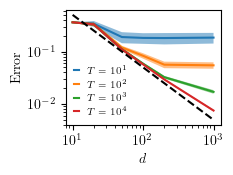

In [8]:
ds = np.asanyarray(ds)
ts = np.asanyarray(ts)
fig, ax = plt.subplots(figsize=(2, 1.5))
for i in range(len(ts)):
    ax.plot(ds, errors_mean[i].numpy(), label=f"$T=10^{int(np.log10(ts[i]))}$")
    ax.fill_between(ds, errors_mean[i].numpy() - .5*errors_std[i].numpy(),
                    errors_mean[i].numpy() + .5*errors_std[i].numpy(), alpha=.5)
ax.plot(ds, 5*ds.astype(float) ** (-alpha + 1), linestyle='--', c="k")
ax.set_xscale('log')
ax.set_xticks([10, 100, 1000], fontsize=6)
ax.set_yscale('log')
# ax.set_yticks([2e-1, 3e-1, 4e-1, 6e-1])
# ax.set_yticklabels([2e-1, 3e-1, 4e-1, 6e-1], fontsize=8)
ax.set_xlabel('$d$', fontsize=10)
ax.set_ylabel('Error', fontsize=10)
plt.legend(loc="best", frameon=False, handlelength=.5, ncol=1, fontsize=7)
fig.savefig('thres_storage_error_d.pdf', bbox_inches='tight')

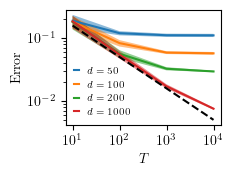

In [9]:
fig, ax = plt.subplots(figsize=(2, 1.5))
for i in range(2, len(ds), 1):
    ax.plot(ts, errors_mean[:, i].numpy(), label=f"$d={ds[i]}$")
    ax.fill_between(ts, errors_mean[:, i].numpy() - .5*errors_std[:, i].numpy(), errors_mean[:, i].numpy() + .5*errors_std[:, i].numpy(), alpha=.5)
ax.plot(ts, .5*ts.astype(float) ** (-1 + 1/alpha), linestyle='--', c="k")
ax.set_xscale('log')
ax.set_xticks([10, 100, 1000, 1e4], fontsize=6)
ax.set_yscale('log')
# ax.set_yticks([1e-4, 1e-2, 1], fontsize=6)
ax.set_xlabel('$T$', fontsize=10)
ax.set_ylabel('Error', fontsize=10)
plt.legend(loc="best", frameon=False, handlelength=.5, ncol=1, fontsize=7)
fig.savefig('thres_storage_error_T.pdf', bbox_inches='tight')

Scaling with respect to d

In [10]:
# number of input tokens
n = 1000
# number of output classes
m = 5
# memory dimension
ds = np.logspace(1, 3, num=20, dtype=int)
dmax = np.max(ds)

# Zipf parameter
alpha = 2

In [11]:
# Population data
all_x = th.arange(n)
proba = (all_x + 1.) ** (-alpha)
proba /= proba.sum()
all_y = modular_class(all_x, m)

In [12]:
nb_trials = 100
errors = th.zeros(3, nb_trials, len(ds))
errors[:] = -1

for i_t in range(nb_trials):
    # Embeddings
    E = get_embeddings(n, dmax, norm=False)
    U = get_embeddings(m, dmax, norm=True)

    W_fill = E.T @ U[all_y]
    W_weight = E.T * proba @ U[all_y]

    for i_d, d in enumerate(ds):
        pred_fill = (E[:, :d] @ W_fill[:d,:d] @ U[:,:d].T).argmax(dim=1)
        pred_weight = (E[:, :d] @ W_weight[:d,:d] @ U[:,:d].T).argmax(dim=1)

        # P = d
        # W = E[:P].T @ U[all_y[:P]]
        # pred_thres1 = (E[:, :d] @ W[:d,:d] @ U[:,:d].T).argmax(dim=1)

        P = int(d / 8)
        W = E[:P].T @ U[all_y[:P]]
        pred_thres2 = (E[:, :d] @ W[:d,:d] @ U[:,:d].T).argmax(dim=1)
        
        errors[0, i_t, i_d] = proba[pred_fill != all_y].sum()
        errors[1, i_t, i_d] = proba[pred_weight != all_y].sum()
        # errors[2, i_t, i_d] = proba[pred_thres1 != all_y].sum()
        errors[2, i_t, i_d] = proba[pred_thres2 != all_y].sum()

In [13]:
errors_mean = errors.mean(dim=1)
errors_std = errors.std(dim=1)

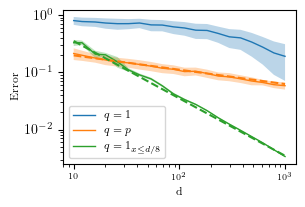

In [14]:
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

fig, ax = plt.subplots(figsize=(3, 2))
# fig, ax = plt.subplots(figsize=(1.5, 1))
leg = []
for i in range(3):
    a, = ax.plot(ds, errors_mean[i], color='C' + str(i), linewidth=1)
    ax.fill_between(ds, errors_mean[i] - .5*errors_std[i], errors_mean[i] + .5*errors_std[i], alpha=.3)
    leg.append(a)

ax.plot(ds, .35*ds**(-1/4), color='C1', linestyle='--')
ax.plot(ds, 3.5*ds**(-1.), color='C2', linestyle='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([10, 100, 1000])
ax.set_xticklabels(["10", r"$10^2$", r"$10^3$"], fontsize=6)
# ax.set_yticks([1e-1, 1e-3, 1e-5])
# ax.set_yticklabels(["$10^{-1}$", r"$10^{-3}$", r"$10^{-5}$"], fontsize=6)
ax.set_xlabel('d', fontsize=8)
ax.set_ylabel(r'Error', fontsize=8)
ax.legend(leg, ['$q=1$', '$q=p$', r'$q = 1_{x\leq d / 8}$'], fontsize=8)
fig.savefig('gen_error_bigN.pdf', bbox_inches='tight')
# fig.savefig('gen_error.pdf', bbox_inches='tight')